In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("clean_data.csv")
df.head()

,Content,Label,num_words
0,move saami governing body us officially correc...,0,108
1,first use word english language term scientolo...,0,907
2,bite vicious tongue,1,24
3,princess serenity barefoot put comment serenit...,0,245
4,keep changing page made please obviously resta...,1,196


In [3]:
df.dropna(how='any', inplace=True)

##### Performing experiments to get the best feature engineering technique between BoW and TF-IDF

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

uri = os.getenv("MLFLOW_URI")
repo_owner = os.getenv("OWNER")
repo_name = os.getenv("REPO")

In [5]:
import mlflow
import dagshub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [6]:
vec = TfidfVectorizer(max_features=2500, min_df=3)

In [7]:
MODELS = {
    "LogisticRegression" : LogisticRegression(solver="lbfgs", penalty='l2', max_iter=2000, C=0.1, n_jobs=-1),
    "GaussianNB" : GaussianNB(),
    "MultinomialNB" : MultinomialNB(),
    "DecisionTree" : DecisionTreeClassifier(max_depth=30),
    "RandomForest" : RandomForestClassifier(n_estimators=500, max_depth=20, n_jobs=-1),
    "ExtraTrees" : ExtraTreesClassifier(n_estimators=500, max_depth=20, n_jobs=-1),
    "GradientBoosting" : GradientBoostingClassifier(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=0.5),
    "XgBoost" : XGBClassifier(n_estimators=500, max_depth=7, learning_rate=0.1, subsample=0.5, n_jobs=-1)
}

In [8]:
import mlflow
import dagshub

if uri is None:
	raise ValueError("MLFLOW_URI environment variable is not set.")
mlflow.set_tracking_uri(uri)

if repo_owner is None:
	raise ValueError("Missing dagshub logging environment credentials.")
dagshub.init(repo_owner=repo_owner, repo_name=repo_name, mlflow=True)

mlflow.set_experiment("Finding Best Model")

Accessing as SubinoyBera

Initialized MLflow to track repo "SubinoyBera/Toxic-TweetTagger"

Repository SubinoyBera/Toxic-TweetTagger initialized!

<Experiment: artifact_location='mlflow-artifacts:/773e34a6851045719bec78f3917279b0', creation_time=1752420283999, experiment_id='4', last_update_time=1752420283999, lifecycle_stage='active', name='Finding Best Model', tags={}>

In [9]:
# Function to log hyperparameters of the trained model to Mlflow
def log_model_params(model_name, model):
    params_to_log = {}

    if model_name == "LogisticRegression":
        params_to_log["solver"] = model.solver
        params_to_log["penalty"] = model.penalty
        params_to_log["C"] = model.C
    
    elif model_name == "GaussianNB":
        params_to_log["var_smoothing"] = model.var_smoothing

    elif model_name == "MultinomialNB":
        params_to_log["alpha"] = model.alpha
        params_to_log["fit_prior"] = model.fit_prior

    elif model_name == "DecisionTree":
        params_to_log["max_depth"] = model.max_depth
        params_to_log["criterion"] = model.criterion

    elif model_name == "RandomForest":
        params_to_log["n_estimator"] = model.n_estimators
        params_to_log["max_depth"] = model.max_depth

    elif model_name == "ExtraTrees":
        params_to_log["n_estimators"] = model.n_estimators
        params_to_log["max_depth"] = model.max_depth

    elif model_name == "GradientBoosting":
        params_to_log["n_estimators"] = model.n_estimators
        params_to_log["learning_rate"] = model.learning_rate
        params_to_log["max_depth"] = model.max_depth

    elif model_name == "XgBoost":
        params_to_log["n_estimators"] = model.n_estimators
        params_to_log["learning_rate"] = model.learning_rate
        params_to_log["max_depth"] = model.max_depth
        params_to_log["tree_method"] = model.tree_method

    mlflow.log_params(params_to_log)

In [12]:
def run_experiments(df):
    for model_name, model_algo in MODELS.items():
        with mlflow.start_run(run_name=f"{model_name}"):
            try:
                print(f"Training {model_name}")
                X = vec.fit_transform(df['Content'])
                y = df['Label'].values.ravel()
    
                mlflow.log_params({
                    "vectorizer" : vec,
                    "model" : model_name}
                )

                # Split data into training and testing
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                if model_name == "GaussianNB" or model_name == "MultinomialNB":
                    # For Naive Bayes, we need to convert sparse matrix to dense
                    X_train = X_train.toarray()
                    X_test = X_test.toarray()
    
                model = model_algo
                model.fit(X_train, y_train)

                print("Logging model hyperparameters to Mlflow")
                log_model_params(model_name, model)

                print("Evaluating model")
                y_pred = model.predict(X_test)
    
                metrics = {
                    "accuracy" : accuracy_score(y_test, y_pred),
                    "precision" : precision_score(y_test, y_pred),
                    "recall" : recall_score(y_test, y_pred),
                    "F1" : f1_score(y_test, y_pred),
                    "roc_auc" : roc_auc_score(y_test, y_pred)
                }

                print("Logging model metrics")
                mlflow.log_metrics(metrics)
                    
                print("Done! \n\n")
    
            except Exception as e:
                print(f"Error in model training and or tracking: {e}")
                raise e

In [13]:
run_experiments(df)

Training LogisticRegression
Logging model hyperparameters to Mlflow
Evaluating model
Logging model metrics
Done! 


🏃 View run LogisticRegression at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/4/runs/c763b2ce5a2a439ead6abb6b74f159d6
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/4
Training GaussianNB
Logging model hyperparameters to Mlflow
Evaluating model
Logging model metrics
Done! 


🏃 View run GaussianNB at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/4/runs/3237f540b82d49dd9408fbb15b10b350
🧪 View experiment at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/4
Training MultinomialNB
Logging model hyperparameters to Mlflow
Evaluating model
Logging model metrics
Done! 


🏃 View run MultinomialNB at: https://dagshub.com/SubinoyBera/Toxic-TweetTagger.mlflow/#/experiments/4/runs/90afcac11d2148e1b4848b00d47dcbe0
🧪 View experiment at: https://dagshub.com/SubinoyBera

In [ ]:
%cd ..

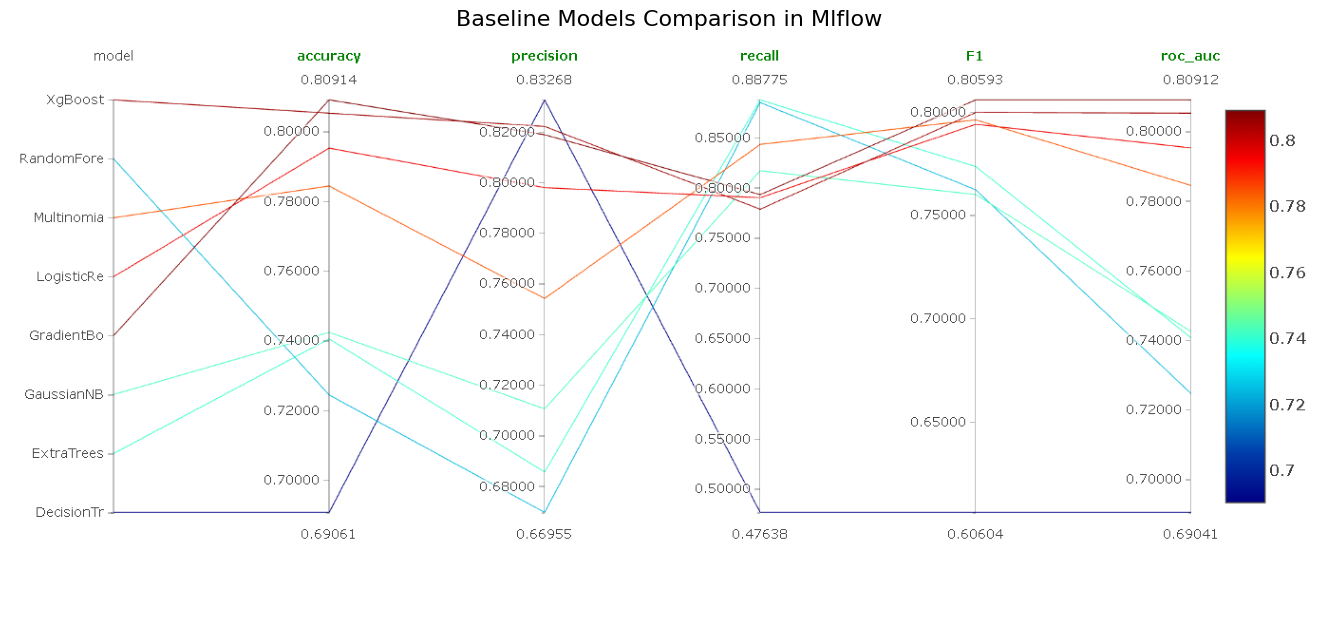

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("images/all_experiments.png")
plt.figure(figsize=(17, 13))
plt.imshow(img)
plt.title("Baseline Models Comparison in Mlflow", fontsize=16, color='black')
plt.axis('off')
plt.show()

We choose XgBoost as our best model from the above experiments for further hyperparameter tuning over Gradient Boosting considering computation constrants and efficiency.